# Восстановление золота из руды
Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

Подготовить данные;
Провести исследовательский анализ данных;
Построить и обучить модель.
Чтобы выполнить проект, обращайтесь к библиотекам pandas, matplotlib и sklearn. Вам поможет их документация.

# Содержание

 - 1. Изучение данных из файла и предобработка  
   - 1.1. Осмотр данных
   - 1.2. Предобработка данных
 - 2. Исследовательский анализ данных
 - 3. Выбор и проверка модели
 - 4. Общий вывод

## Изучение данных из файла и предобработка
### Осмотр данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

In [2]:
try:
    df = pd.read_csv('gold_recovery_full_new.csv')
except:
    df = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
try:
    train = pd.read_csv('gold_recovery_train_new.csv')
except:
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv')

In [4]:
try:
    test = pd.read_csv('gold_recovery_test_new.csv')
except:
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [5]:
display(df.shape)
display(train.shape)
display(test.shape)

(19439, 87)

(14149, 87)

(5290, 53)

Можно отметить, что данные уже разбиты на обучающую и тестовую выборки в соотношении близком к 3:1.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Есть немного пропусков и дата в формате 'object', разберемся с этим немного позднее.  
Для начала проверим правильность расчета эффективности обогащения на примере признака 'rougher.output.recovery':

In [7]:
# высчитываем по формуле представленной в описании технологического процесса
def recovery_test(row):
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    c = row['rougher.output.concentrate_au']
    result = (c * (f - t)) / (f * (c - t)) * 100
    return result

Для удобства добавим столбец с нашими расчетами.

In [8]:
train['test'] = train.apply(recovery_test, axis=1)

In [9]:
# сравниваем с результатами из датафрейма
mean_absolute_error(train['rougher.output.recovery'], train['test'])

9.73512347450521e-15

Значение MAE очень близко к нулю, данным можно доверять.  
Сразу же избавляемся от тестового столбца:

In [10]:
train.shape

(14149, 88)

In [11]:
train = train.drop('test', axis=1)

In [12]:
train.shape

(14149, 87)

Теперь осмотрим тестовую выборку.

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Можно подметить, все недостающие данные относятся к типам output и calculation, то есть это данные полученные после каждого из этапов очистки и расчетные характеристики.  
Привести данные в выборках к общему виду можно двумя способами: заново разбить общий датафрейм или достать из него нужные столбцы для тестовой выборки и удалить лишние в обучающей.  
Поскольку нам изначально предоставлены две выборки, сделаем выбор в пользу второго варианта.

### Предобработка данных

В качестве связующего звена между датасетами можно использовать столбец с датой, приведем их к формату datetime.

In [14]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d %H:%M:%S')

Проверяем наличие повторяющихся значений.

In [15]:
df['date'].duplicated().sum()

0

Для начала создадим список из целевых признаков для тестовой выборки.

In [16]:
missing_targets = ['rougher.output.recovery', 'final.output.recovery']

Добавим к ним дату, будем использовать её в качестве индекса.

In [17]:
missing_targets.append('date')

Присоединяем недостающие таргеты методом merge.

In [18]:
test.shape

(5290, 53)

In [19]:
test = test.merge(df[missing_targets], on='date', how='inner')
test.shape

(5290, 55)

Теперь получим список недостающих столбцов.

In [20]:
missing_columns = list(set(train.columns).difference(test.columns))

И удалим их из обучающей выборки.

In [21]:
train.shape

(14149, 87)

In [22]:
train = train.drop(columns=missing_columns)
train.shape

(14149, 55)

In [23]:
test.shape

(5290, 55)

Осталось разобраться с пропусками.  
Их довольно немного, заполним их предыдущими значениями.

In [24]:
train = train.ffill(axis = 0)
test = test.ffill(axis = 0)
df = df.ffill(axis = 0)

## Исследовательский анализ данных

Посмотрим как меняется концентрация металлов на различных этапах очистки.  
Соберем в список данные по Au, Ag и Pb на каждом из этапов.

In [25]:
metals = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au',
    'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au','rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 
          'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_au',
          'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb','secondary_cleaner.output.tail_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au',
         'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_au']

In [26]:
df[metals].mean()

rougher.input.feed_ag                     8.794927
rougher.input.feed_pb                     3.585096
rougher.input.feed_au                     8.266097
rougher.output.concentrate_ag            11.994759
rougher.output.concentrate_pb             7.606272
rougher.output.concentrate_au            19.772000
rougher.output.tail_ag                    5.589064
rougher.output.tail_pb                    0.645782
rougher.output.tail_au                    1.816391
primary_cleaner.output.concentrate_ag     8.442408
primary_cleaner.output.concentrate_pb     9.810317
primary_cleaner.output.concentrate_au    32.119400
primary_cleaner.output.tail_ag           16.145888
primary_cleaner.output.tail_pb            3.433558
primary_cleaner.output.tail_au            3.914179
secondary_cleaner.output.tail_ag         14.586720
secondary_cleaner.output.tail_pb          5.776428
secondary_cleaner.output.tail_au          4.339625
final.output.concentrate_ag               5.168387
final.output.concentrate_pb    

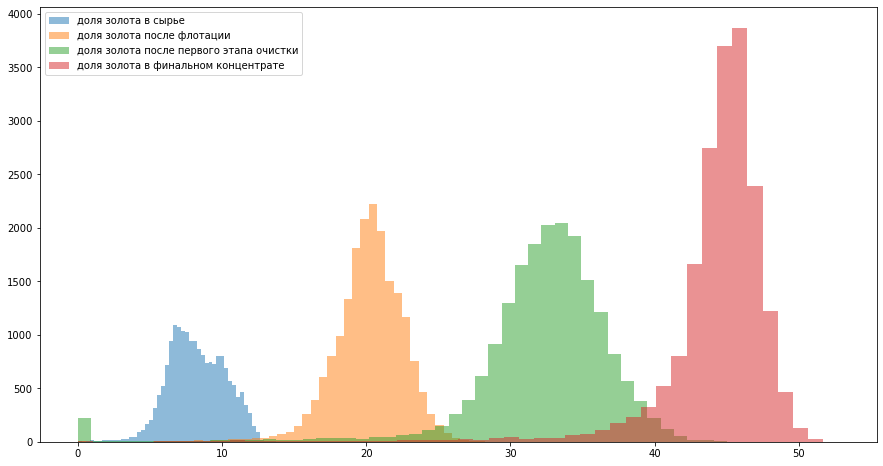

In [88]:
plt.figure(figsize=(15, 8))
plt.hist(df['rougher.input.feed_au'], bins=50, alpha=0.5, label='доля золота в сырье')
plt.hist(df['rougher.output.concentrate_au'], bins=50, alpha=0.5, label='доля золота после флотации')
plt.hist(df['primary_cleaner.output.concentrate_au'], bins=50, alpha=0.5, label='доля золота после первого этапа очистки')
plt.hist(df['final.output.concentrate_au'], bins=50, alpha=0.5, label='доля золота в финальном концентрате')
plt.legend(loc='upper left')

Доля золота в концентрате растёт с каждым этапом очистки, что не удивительно, ведь на это и направлен весь процесс.  
Доля серебра в хвостах значительно превосходит два других металла, что также ведет к постоянному снижению его доли в концентратах.

<div class="alert alert-success"> ✅ 
<h3> Комментарий ревьюера v2</h3>

👍


Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

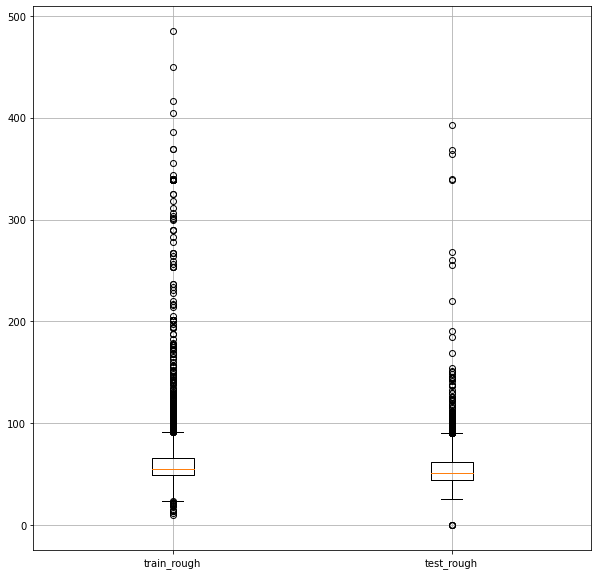

In [28]:
train_rough = train['rougher.input.feed_size']
train_primary = train['primary_cleaner.input.feed_size']
test_rough = test['rougher.input.feed_size']
test_primary = test['primary_cleaner.input.feed_size']
bp_data = [train_rough, test_rough]
plt.figure(figsize=(10, 10))
plt.boxplot(bp_data)
plt.xticks([1, 2], ['train_rough', 'test_rough'])
plt.grid()

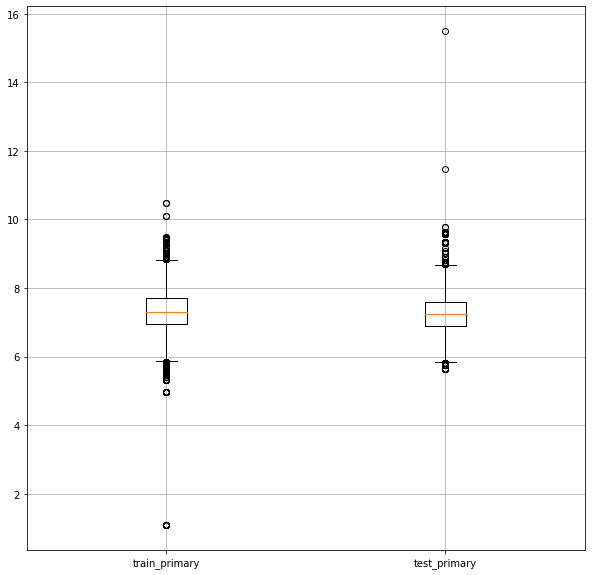

In [29]:
bp_data = [train_primary, test_primary]
plt.figure(figsize=(10, 10))
plt.boxplot(bp_data)
plt.xticks([1, 2], ['train_primary', 'test_primary'])
plt.grid()

Основная масса значений ноходится в одном диапазоне, данное распределение подходит для обучения и проверки модели.

Теперь изучим распределение суммарной концентрации веществ на разных стадиях.

In [30]:
df['total_rough_input'] = df['rougher.input.feed_ag'] + df['rougher.input.feed_pb'] + df['rougher.input.feed_sol'] + df['rougher.input.feed_au']
df['total_rough_output'] = df['rougher.output.concentrate_ag'] + df['rougher.output.concentrate_pb'] + df['rougher.output.concentrate_sol'] + df['rougher.output.concentrate_au']
df['total_final_output'] = df['final.output.concentrate_ag'] + df['final.output.concentrate_pb'] + df['final.output.concentrate_sol'] + df['final.output.concentrate_au']

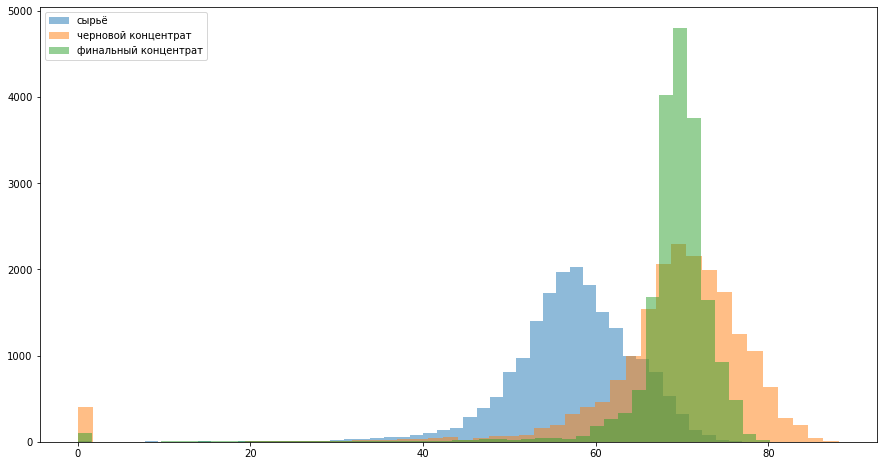

In [31]:
plt.figure(figsize=(15, 8))
plt.hist(df['total_rough_input'], bins=50, alpha=0.5, label='сырьё')
plt.hist(df['total_rough_output'], bins=50, alpha=0.5, label='черновой концентрат')
plt.hist(df['total_final_output'], bins=50, alpha=0.5, label='финальный концентрат')
plt.legend(loc='upper left')

Больше всего нас интересуют нулевые значения, это может быть как результатом ошибки в записи данных, так и следствием сбоя в работе очистной установки.  
В любом случае, эти данные не помогут в обучении модели, поэтому стоит просто удалить их.

In [32]:
df.shape

(19439, 90)

In [33]:
df = df[df['total_rough_input'] > 0]
df = df[df['total_rough_output'] > 0]
df = df[df['total_final_output'] > 0]

In [34]:
df.shape

(18949, 90)

Также избавляемся от промежуточных столбцов.

In [35]:
df = df.drop(columns=['total_rough_input', 'total_rough_output', 'total_final_output'])
df.shape

(18949, 87)

В обучающей и тестовой выборках присутствует только столбец 'rougher.input.feed_pb', проведем ту же процедуру, но только с этим признаком.

In [36]:
display(train.shape)
display(test.shape)

(14149, 55)

(5290, 55)

In [37]:
train['total_rough_input'] = train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] + train['rougher.input.feed_sol'] + train['rougher.input.feed_au']
test['total_rough_input'] = test['rougher.input.feed_ag'] + test['rougher.input.feed_pb'] + test['rougher.input.feed_sol'] + df['rougher.input.feed_au']
train = train[train['total_rough_input'] > 0]
test = test[test['total_rough_input'] > 0]
display(train.shape)
display(test.shape)

(14149, 56)

(5173, 56)

In [38]:
train.shape

(14149, 56)

In [39]:
train = train.drop(columns='total_rough_input')
train.shape

(14149, 55)

In [40]:
test.shape

(5173, 56)

In [41]:
test = test.drop(columns='total_rough_input')
test.shape

(5173, 55)

## Выбор и проверка модели

Перейдем к выбору модели и параметров.  
Целевых признака у нас два: 'rougher.output.recovery' и 'final.output.recovery'.

In [83]:
features_train = train.drop(columns=['date', 'rougher.output.recovery', 'final.output.recovery'])
target_train = train[['rougher.output.recovery', 'final.output.recovery']]

В библиотеке sklearn нет функции вычисления sMAPE, её необходимо написать вручную.  
Напишем её таким образом, чтобы сразу получать итоговое sMAPE.

In [43]:
def smape(target, predictions):
    i =  1/len(target) * np.sum(np.abs(predictions-target) / ((np.abs(target) + np.abs(predictions)/2))*100)
    return i[0] * 0.25 + i[1] * 0.75

И используем make_scorer на неё, чтобы иметь возможность применить её при кросс-валидации.

In [44]:
scorer = make_scorer(smape, greater_is_better=False)

Выбирать будем между линейной регрессией и деревом решений, случайный лес, увы, работает слишком медленно.  
Интересующие нас параметры линейной регрессии имеют тип bool, поэтому их можно проверить и вручную через cross_val_score

In [45]:
# тут уже финальные параметры с лучшим результатом
model = LinearRegression(copy_X=True, fit_intercept=False, normalize=True)
cross_val_score(model, features_train, target_train, scoring=scorer, cv=4)

array([ -8.58372598,  -7.82142496, -10.67839397,  -8.41541232])

С деревом решений уже стоит применить GridSearchCV.

In [46]:
%%time 
model = DecisionTreeRegressor()
parameters = {'max_depth':[10, 30, 50, 70], 'min_samples_split':[2, 4, 6, 8], 'min_samples_leaf':[1, 3, 5, 7]}
grid = GridSearchCV(model, parameters, scoring=scorer, cv=4)
grid.fit(features_train, target_train)
display(grid.best_params_)
display(grid.best_score_)

{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 8}

-9.088087112565168

Wall time: 2min 39s


Сделаем выбор в пользу дерева решений с параметрами: max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2  
Осталось только проверить модель на тестовой выборке.

In [82]:
features_test = test.drop(columns=['date', 'rougher.output.recovery', 'final.output.recovery'])
target_test = test[['rougher.output.recovery', 'final.output.recovery']]

In [60]:
model = DecisionTreeRegressor(random_state=12345, max_depth=10, min_samples_leaf=3, min_samples_split=2)
model.fit(features_train, target_train)
prediction = model.predict(features_test)
smape_results = smape(target_test, prediction)
smape_results

8.892079886800508

Поскольку целевого значения метрики в задании нет, стоит сравнить его с результатом константной модели.

In [89]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
prediction_dummy = dummy.predict(features_test)
dummy_result = smape(target_test, prediction_dummy)
dummy_result

7.585390787637328

Увы, результат не сильно отличается от модели заполняющей всё средним значением.  
Можно сделать вывод о недостаточности предоставленныъ данных для эффективного обучения моделей.  
Остается только запросить новые данные.

## Общий вывод

При осмотре датасета были обнаружены отличия в данных обучающей и тестовой выборок.  
Недостающие целевые признаки для тестовой выборки были получены из общего датасета с использование даты в качестве индекса.  
Признаки отсутствующие в тестовой выборке были удалены из обучающей.
Пропуски были заполнены предыдущими значениями.
В результате исследовательского анализа были обнаружены и удалены аномалии в данных.  
Была написана функция для вычисления метрики качества sMAPE.  
Были обучены и проверены методом кросс-валидации несколько моделей.  
Выбранная модель дерева решений была проверена на тестовой выборке.
В результате сравнения с константной моделью, предоставленные данные признаны недостаточными для эффективного обучения моделей.  
Для построения успешной модели требуются другие данные или же ищменение условий задачи.